This tutorial demonstrates how to generate a particle_dataset in Relion using `cryojax`. This tutorial builds upon tools already shown in other tutorials, so we might skip over some details.

In [1]:
%load_ext autoreload
%autoreload 2

First we will do all the imports required to run the tutorial

In [2]:
# Jax and Equinox imports
from functools import partial

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import PRNGKeyArray

In [3]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [4]:
# CryoJAX imports

import cryojax.simulator as cxs
from cryojax.data import (
    RelionParticleParameterDataset,
    RelionParticleParameters,
    RelionParticleStackDataset,
    write_simulated_image_stack_from_starfile,
    write_starfile_with_particle_parameters,
)
from cryojax.image import operators as op
from cryojax.io import read_atoms_from_pdb
from cryojax.rotations import SO3

# Generating a starfile

We have split this tutorial in two parts. In the first part we will generate a starfile, but we will not generate any particles. In the second part we will show how to generate particles from a starfile, and how to save such particles to the respective MRC Files.

We have decided to keep this two steps separate for a simple reason, flexibility. We want to make it possible for every user to design their own image formation pipeline. In some of our other tutorials we have showed how to generate noiseless image, images with solvent noise, or images with noise coming from a distribution. You can easily adapt this tutorial to those cases, or any other pipeline you build.

Now we will start by generating a starfile. To do this, we will first create a cryojax RelionParticleParameterDataset.

In this function we vmap over `jax` random keys. You can adapt this function to your needs, such as adapting the range of the distributions for the random parameters, or changing wheter a parameter is random or not.

In [ ]:
# @partial(eqx.filter_vmap, in_axes=(0, None), out_axes=(eqx.if_array(0), None))
@partial(eqx.filter_vmap, in_axes=(0, None))
def make_particle_parameters(
    key: PRNGKeyArray, instrument_config: cxs.InstrumentConfig
):  # -> tuple[RelionParticleParameters, RelionParticleParameters]:
    # Generate random parameters

    # Pose
    # ... instantiate rotations
    key, subkey = jax.random.split(key)  # split the key to use for the next random number
    rotation = SO3.sample_uniform(subkey)

    # ... now in-plane translation
    ny, nx = instrument_config.shape

    key, subkey = jax.random.split(key)  # do this everytime you use a key!!
    offset_in_angstroms = (
        jax.random.uniform(subkey, (2,), minval=-0.2, maxval=0.2)
        * jnp.asarray((nx, ny))
        * instrument_config.pixel_size
    )
    # ... build the pose
    pose = cxs.EulerAnglePose.from_rotation_and_translation(rotation, offset_in_angstroms)

    # CTF Parameters
    # ... defocus
    key, subkey = jax.random.split(key)
    defocus_in_angstroms = jax.random.uniform(subkey, (), minval=10000, maxval=15000)

    key, subkey = jax.random.split(key)
    astigmatism_in_angstroms = jax.random.uniform(subkey, (), minval=0, maxval=100)

    key, subkey = jax.random.split(key)
    astigmatism_angle = jax.random.uniform(subkey, (), minval=0, maxval=jnp.pi)

    key, subkey = jax.random.split(key)
    phase_shift = jax.random.uniform(subkey, (), minval=0, maxval=0)
    # no more random numbers needed

    # now generate your non-random values
    spherical_aberration_in_mm = 2.7
    amplitude_contrast_ratio = 0.1
    b_factor = 0.0
    ctf_scale_factor = 1.0

    # ... build the CTF
    transfer_theory = cxs.ContrastTransferTheory(
        ctf=cxs.CTF(
            defocus_in_angstroms=defocus_in_angstroms,
            astigmatism_in_angstroms=astigmatism_in_angstroms,
            astigmatism_angle=astigmatism_angle,
            spherical_aberration_in_mm=spherical_aberration_in_mm,
        ),
        envelope=op.FourierGaussian(b_factor=b_factor, amplitude=ctf_scale_factor),
        amplitude_contrast_ratio=amplitude_contrast_ratio,
        phase_shift=phase_shift,
    )

    particle_parameters = RelionParticleParameters(
        instrument_config=instrument_config,
        pose=pose,
        transfer_theory=transfer_theory,
    )

    return particle_parameters

In [6]:
# Generate instrument config
instrument_config = cxs.InstrumentConfig(
    shape=(128, 128),
    pixel_size=1.5,
    voltage_in_kilovolts=300.0,
    pad_scale=1.0,  # no padding
)

# Generate RNG keys
number_of_images = 100
keys = jax.random.split(jax.random.key(0), number_of_images)

# ... instantiate the RelionParticleParameterDataset
# particle_parameters_vmap, particle_parameters_novmap = make_particle_parameters(
#     keys, instrument_config
# )

particle_parameters = make_particle_parameters(keys, instrument_config)

To see the values of any particular parameter, you can do

Lastly, we can easily generate the starfile from the built-in `cryojax.data.write_starfile_with_particle_parameters` function.

The `mrc_batch_size` parameter let's you specify how many particles you want per mrcfile.

In this case we will place 50 images per mrcfile, giving us two mrcfiles. Just for clarification, we are not generating any mrc files in this step, this is merely for naming them in the mrcfile and assigning each image their respective parameters.

In [7]:
# ... generate the starfile
# particle_parameters = eqx.combine(particle_parameters_vmap, particle_parameters_novmap)
write_starfile_with_particle_parameters(
    particle_parameters,
    "./outputs/relion_dataset.star",
    mrc_batch_size=50,
    overwrite=True,
)

# Simulating particles based on a starfile and writing them to mrcs

Now we will see how to define the functions required for our `write_simulated_image_stack_from_starfile` function to work.

First, let's load the starfile we generated in the previous step. We will also define some objects required to generate images.

## Simulating noiseless images

First, we will generate a stack without noise using one of `cryojax` imaging pipelines.

In [8]:
# First load the starfile

path_to_mrc_files = "./outputs/relion_dataset_particles/noiseless"

parameter_dataset = RelionParticleParameterDataset(
    path_to_starfile="./outputs/relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    loads_envelope=True,
)

!!! info "For more information on reading data in RELION, check our `Read a particle stack` tutorial."

Now let's define the structure we will use to generate images. In this case, we show how to load a pdb and then turn it into a voxel grid. We all need to define how we will integrate our potential.

In [ ]:
from cryojax.constants import (
    get_tabulated_scattering_factor_parameters,
    read_peng_element_scattering_factor_parameter_table,
)


filename = "./data/groel_chainA.pdb"
atom_positions, atom_identities, b_factors = read_atoms_from_pdb(
    filename, center=True, select="not element H", loads_b_factors=True
)
scattering_factor_parameters = get_tabulated_scattering_factor_parameters(
    atom_identities, read_peng_element_scattering_factor_parameter_table()
)
atomic_potential = cxs.PengAtomicPotential(
    atom_positions,
    scattering_factor_a=scattering_factor_parameters["a"],
    scattering_factor_b=scattering_factor_parameters["b"],
    b_factors=b_factors,
)

# get values from the "optics" datablock in the starfile
box_size = parameter_dataset[0].instrument_config.shape[0]
voxel_size = parameter_dataset[0].instrument_config.pixel_size

real_voxel_grid = atomic_potential.as_real_voxel_grid(
    shape=(box_size, box_size, box_size), voxel_size=voxel_size
)

# It is usually faster to simulate images from a volume than from
# and atomic potential. Unless you are using multiple potentials
# or very few images.
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=2
)

potential_integrator = cxs.FourierSliceExtraction()

Now we will build a function that generates an imaging pipeline from the parameter dataset

In [10]:
def build_image_model_from_particle_parameters(
    relion_particle_parameters: RelionParticleParameters,
    potential: cxs.AbstractPotentialRepresentation,
    potential_integrator: cxs.AbstractPotentialIntegrator,
) -> cxs.ContrastImageModel:
    structural_ensemble = cxs.SingleStructureEnsemble(
        potential, relion_particle_parameters.pose
    )

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        relion_particle_parameters.transfer_theory,
    )
    image_model = cxs.ContrastImageModel(
        relion_particle_parameters.instrument_config, scattering_theory
    )
    return image_model

and a function that simply computes images from relion particle parameters.

This function takes as input an instance of a RelionParticleParameters object. This should only contain information for one image! For example, this could be the output of `parameter_dataset[idx]`. The `constant_args` argument should be a PyTree that does not change between images. In this case we use our `potential` and `potential_integrator`

In [11]:
from typing import Tuple

from jaxtyping import Array, Float


def compute_image(
    particle_parameters: RelionParticleParameters,
    constant_args: Tuple[
        cxs.AbstractPotentialRepresentation, cxs.AbstractPotentialIntegrator
    ],
) -> Float[Array, "y_dim x_dim"]:
    potential, potential_integrator = constant_args

    image_model = build_image_model_from_particle_parameters(
        particle_parameters, potential, potential_integrator
    )
    return image_model.render()

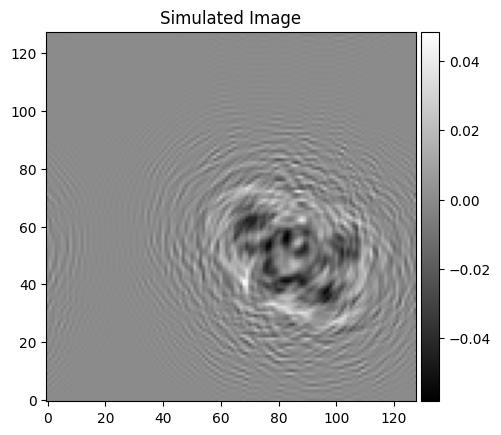

In [12]:
image = compute_image(
    parameter_dataset[0], constant_args=(potential, potential_integrator)
)
plot_image(image, plt.figure(), plt.gca(), label="Simulated Image");

Finally, we can use this function to write a particle stack!

!!! info "Our `write_simulate_image_stack_from_starfile` function expects your image computation function to be defined as `def myimage_comp_func(particle_parameters, constant_args, per_particle_args)`. However, the function defined above does not satisfy this as we do not use `per_particle_args`. Let's see how to get around this"

In [13]:
write_simulated_image_stack_from_starfile(
    parameter_dataset,
    lambda particle_params, const_args, _: compute_image(
        particle_params, const_args
    ),  # defines a new function
    constant_args=(potential, potential_integrator),
    # per_particle_args=None,  # this is the default value
    is_jittable=True,
    batch_size_per_mrc=10,
    overwrite=True,
    compression=None,
)

!!! info "How does `write_simulated_image_stack_from_starfile` work?"

    The arguments to call this function are:

    - `parameter_dataset`: needs to be an instance of `RelionParticleParameterDataset`
    - `compute_image_fn`: function that should take (RelionParticleParameters, constant_args, per_particle_args) as input. The names are not strict, but the structure is.
    - `constant_args`: the args for `compute_image_fn` that do not change between images.
    - `per_particle_args`: the arguments for `compute_image_fn` with batch dimention equal to the number of images.
    - `is_jittable`: whether or not your function can be jitted with `equinox.filter_jit`. (If you are not sure, run it and set it to False if it does not work)
    - `batch_size_per_mrc`: if your function is jittable we will vmap the computation of the images, which might have a big memory usage. If you get some "Ran out of memory" error, then adjust this batch size. Setting it to "None" will assume no batching needs to be done. Setting it to 1 runs the code in serial mode. This is still faster than running it with `is_jittable=False`.
    - `overwrite`: whether or not you want existing files to be overwritten.
    - `compression`: mrcfile compression, see the `mrcfile` library docs for more information.


    Inside our code we will call your `compute_image_fn` function to generate an image stack, and then save it as an mrcfile.

!!! info "For more information on imaging pipelines check the `Simulate an image` tutorial."

## Simulating images with a noise distribution

In this example we will use a cryojax distribution to add the noise, but in practice you can do it however you want.

We need a different dataset, as we will save these images in a different folder

In [14]:
# First load the starfile

path_to_mrc_files = "./outputs/relion_dataset_particles/with_noise"

parameter_dataset_for_noise_images = RelionParticleParameterDataset(
    path_to_starfile="./outputs/relion_dataset.star",  # starfile we created
    path_to_relion_project=path_to_mrc_files,  # here is where the mrcs will be saved
    loads_envelope=True,
)

the other parameters do not change, so there is no need to initialize them again.

We will follow a simular approach as before. First, let's write a function that generates a distribution from a `RelionParticleParameters`:

In [15]:
from cryojax.inference import distributions as dist


def build_distribution_from_particle_parameters(
    particle_parameters: RelionParticleParameters,
    potential: cxs.AbstractPotentialRepresentation,
    potential_integrator: cxs.AbstractPotentialIntegrator,
    noise_variance: float,
) -> dist.IndependentGaussianFourierModes:
    structural_ensemble = cxs.SingleStructureEnsemble(potential, particle_parameters.pose)

    scattering_theory = cxs.WeakPhaseScatteringTheory(
        structural_ensemble,
        potential_integrator,
        particle_parameters.transfer_theory,
    )
    image_model = cxs.ContrastImageModel(
        particle_parameters.instrument_config, scattering_theory
    )
    distribution = dist.IndependentGaussianFourierModes(
        image_model,
        signal_scale_factor=jnp.sqrt(instrument_config.n_pixels),
        variance_function=op.Constant(noise_variance),
    )
    return distribution

and a function that generates an image. To showcase how the `per_particle_args` work we will add a couple of parameters. We will change the variance of the noise for each image, add a scaling factor, and define a `JAX` random key for each instance of noise generation.

In [ ]:
def compute_image_with_noise(
    relion_particle_parameters: RelionParticleParameters,
    constant_args: Tuple[
        cxs.AbstractPotentialRepresentation, cxs.AbstractPotentialIntegrator
    ],
    per_particle_args: Tuple[float, float, PRNGKeyArray],
):
    potential, potential_integrator = constant_args
    noise_variance, scale_factor, key = per_particle_args

    distribution = build_distribution_from_particle_parameters(
        relion_particle_parameters, potential, potential_integrator, noise_variance
    )
    return scale_factor * distribution.sample(key)

and generate an image from such distribution

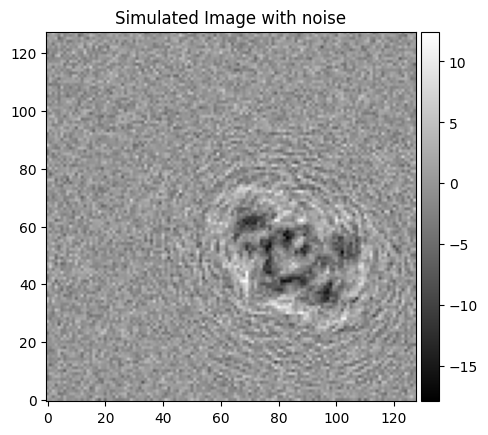

In [17]:
key = jax.random.key(0)

image_with_noise = compute_image_with_noise(
    parameter_dataset_for_noise_images[0],
    (potential, potential_integrator),
    (1.0, 2.0, key),
)
plot_image(image_with_noise, plt.figure(), plt.gca(), label="Simulated Image with noise");

Lastly, let's generate a stack with noise

In [18]:
keys = jax.random.split(key, number_of_images)
variances = jnp.linspace(1.0, 10.0, number_of_images)
scale_factors = jnp.linspace(1.0, 2.0, number_of_images)

constant_args = (potential, potential_integrator)
per_particle_args = (variances, scale_factors, keys)

write_simulated_image_stack_from_starfile(
    parameter_dataset_for_noise_images,
    compute_image_with_noise,
    constant_args=constant_args,
    per_particle_args=per_particle_args,
    is_jittable=True,
    overwrite=True,
)

Now we can load our images using `RelionParticleStackDataset` objects

In [19]:
particle_dataset_noiseless = RelionParticleStackDataset(parameter_dataset)
particle_dataset_noisy = RelionParticleStackDataset(parameter_dataset_for_noise_images)

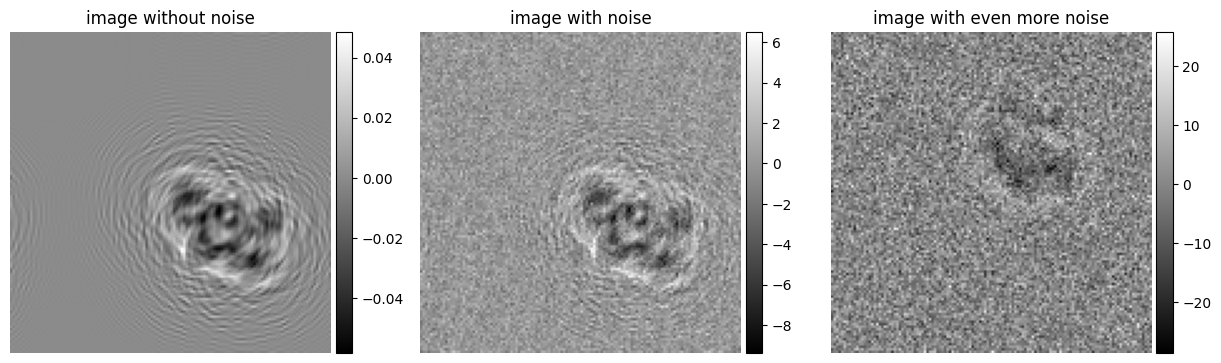

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for a in ax:
    a.set_axis_off()

im1 = plot_image(
    particle_dataset_noiseless[0].images,
    fig,
    ax[0],
    label="image without noise",
)

im2 = plot_image(
    particle_dataset_noisy[0].images,
    fig,
    ax[1],
    label="image with noise",
)

im3 = plot_image(
    particle_dataset_noisy[-1].images,
    fig,
    ax[2],
    label="image with even more noise",
)